In [203]:
from train import mnist_loaders

import torch.nn as nn
import torch.nn.functional as F
import NEmon
from train import expand_args, MON_DEFAULTS, NESingleConvNet, NESingleFcNet, NEMultiConvNet
import splitting as sp
from utils import load_model

from tqdm.notebook import tqdm
import numpy as np

from train import cuda
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [321]:
# Redifine modules so they return fixed point in addition to label

class NESingleFcNetZ(NESingleFcNet):

    def __init__(self, splittingMethod, in_dim=784, out_dim=100, m=0.1, labels=10, **kwargs):
        super().__init__(splittingMethod, in_dim=in_dim, out_dim=out_dim, m=m, labels=labels, **kwargs)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        z = self.mon(x)
        return self.Wout(z[-1]), z# + self.D(x)

class NESingleConvNetZ(NESingleConvNet):

    def __init__(self, splittingMethod,  in_channels=1, out_channels=32, labels=10, m=0.1, **kwargs):
        super().__init__(splittingMethod, in_channels=in_channels, out_channels=out_channels, labels=labels, m=m, **kwargs)

    def forward(self, x,  max_iter = None, max_alpha = None):
        x = F.pad(x, (1, 1, 1, 1))
        z1 = self.mon(x, max_iter=max_iter, max_alpha=max_alpha)
        z2 = F.avg_pool2d(z1[-1], self.pool)
        return self.Wout(z2.view(z2.shape[0], -1)), (*z1, z2)

class NEMultiConvNetZ(NEMultiConvNet):
    def __init__(self, splittingMethod, in_dim=28, in_channels=1,
                 conv_sizes=(16, 32, 64), labels=10, m=1.0, **kwargs):
        super().__init__(splittingMethod, in_dim=in_dim, in_channels=in_channels,
                 conv_sizes=conv_sizes, labels=labels, m=m, **kwargs)

    def forward(self, x,  max_iter = None, max_alpha = None):
        x = F.pad(x, (1,1,1,1))
        zs = self.mon(x,  max_iter=max_iter, max_alpha=max_alpha)
        z = zs[-1]
        z = z.view(z.shape[0],-1)
        return self.Wout(z), zs

In [322]:
splitting_method = sp.NEmonForwardStep
m=.1
fnnz = NESingleFcNetZ(splitting_method,
                         in_dim=28**2,
                         labels=10,
                         out_dim=100,
                         alpha=0.5,
                         max_iter=300,
                         tol=1e-2,
                         m=m).to(device)

scnnz = NESingleConvNetZ(splitting_method,
                         in_channels=1,
                         out_channels=64,
                         labels=10,
                         alpha=0.5,
                         max_iter=300,
                         tol=1e-2,
                         m=m).to(device)

mcnnz = NEMultiConvNetZ(splitting_method,
                                in_dim=28,
                         in_channels=1,
                       conv_sizes=(16, 32, 64),
                       labels=10,
                       alpha=0.5,
                       max_iter=400,
                       tol=1e-2,
                       m=m).to(device)



MAX ITER: 300
MAX ITER: 300
MAX ITER: 400


In [128]:
# Load Models
load_model(fnnz, 'trained/fnn_mnist')
load_model(scnnz, 'trained/scnn_mnist')
load_model(mcnnz, 'trained/mcnn_mnist')

Model loaded from to: trained/fnn_mnist
Model loaded from to: trained/scnn_mnist
Model loaded from to: trained/mcnn_mnist


In [61]:
train, test = mnist_loaders(train_batch_size =120, test_batch_size=120)

In [342]:
def get_embedding_data(model, dataset, num_embs):
    zs = [[] for i in range(num_embs)]
    ys = []

    j= 0 

    for x, y in train:
        j = j+1  +1
        x= cuda(x)
        y= cuda(y)
        p, z = model(x)

        assert(len(z) == num_embs)
        for i in range(num_embs):
            zs[i].append(z[i].flatten(start_dim=1).data.cpu().numpy())
        
        ys.append(y.data.cpu().numpy())
        # print(j)
        # if j >= 3:
        #     break
    labels = np.concatenate(ys)
    embs = [np.concatenate(zs[i], axis=0) for i in range(num_embs)]
    return embs, labels

In [337]:
labels_f.shape

(60000,)

In [336]:
print(len(embs_f), embs_f[0].shape)
#print(len(embs_s), embs_s[0].shape,embs_s[1].shape)
print(embs_s[0].shape)

1 (60000, 100)
(240, 57600)


In [334]:
embs_f, labels_f = get_embedding_data(fnnz, test, 1)

In [343]:
embs_s, labels_s = get_embedding_data(scnnz, test, 2)


In [344]:
embs_m2, labels_m2 = get_embedding_data(mcnnz, test, 3)

In [347]:
embs_m2[0].shape

(60000, 14400)

In [348]:
embs_m2[1].shape

(60000, 8192)

# Dim Reduction

In [366]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

In [349]:
def plot_pca(data, labels,title):
    pca = PCA(n_components=2)
    pca.fit(data)
    p_data = pca.transform(data)
    

PCA(n_components=2)

In [433]:
def plot_pca(data, labels, title):
    data = data - np.mean(data, axis=0)
    pca = PCA(n_components=2, svd_solver='arpack')
    pca.fit(data)
    p_data = pca.transform(data)
    plt.scatter(p_data[:,0],p_data[:,1], c=labels, cmap='rainbow')
    plt.title(title)


def plot_tsne(data, labels, title):
    data = data - np.mean(data, axis=0)
    pca = PCA(n_components=10, svd_solver='arpack')
    pca.fit(data)
    p_data = pca.transform(data)

    tsne = TSNE()
    t_data = tsne.fit_transform(p_data)

    plt.scatter(t_data[:,0],t_data[:,1], c=labels, cmap='rainbow')
    plt.title(title + " TSNE")

In [434]:
plot_tsne(embs_f[0][0:100], labels_f, "Feed Forward")

/data/home/sjaffe/miniconda3/envs/koopman/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data/home/sjaffe/miniconda3/envs/koopman/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

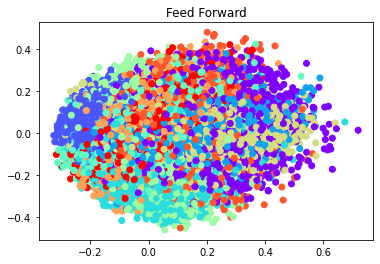

In [411]:
plot_pca(embs_f[0], labels_f, "Feed Forward")

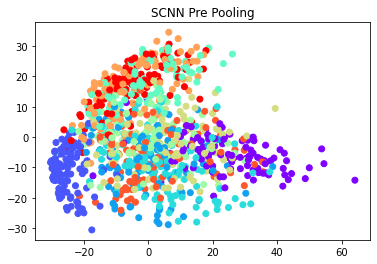

In [413]:
plot_pca(embs_s[0][0:1000], labels_s[0:1000], "SCNN Pre Pooling")


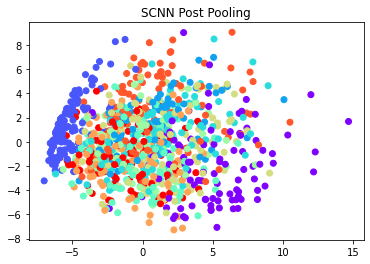

In [414]:
plot_pca(embs_s[1][0:1000], labels_s[0:1000], "SCNN Post Pooling")


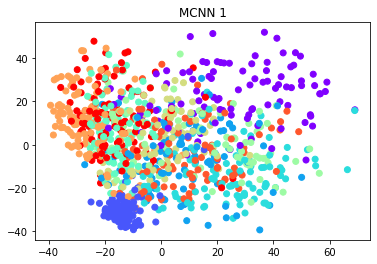

In [426]:
plot_pca(embs_m2[0][0:1000], labels_m2[0:1000], "MCNN 1")


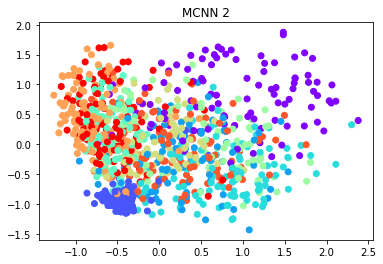

In [427]:
plot_pca(embs_m2[1][0:1000], labels_m2[0:1000], "MCNN 2")


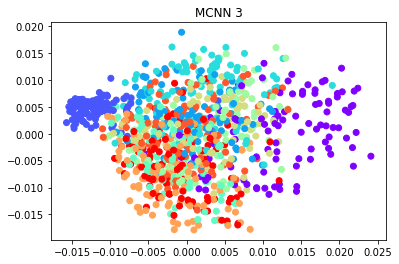

In [428]:
plot_pca(embs_m2[2][0:1000], labels_m2[0:1000], "MCNN 3")
